In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
#sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import rcParams


In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
table_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/tables/new/'
figure_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/figures/new/'


In [3]:
adata = sc.read_h5ad(path+'data/ALO_viscRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 21044 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [4]:
filtered =adata[adata.obs.high_quality=='True']
filtered

View of AnnData object with n_obs × n_vars = 20672 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [5]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered.copy()
filtered.layers['raw'] = filtered.X.copy()

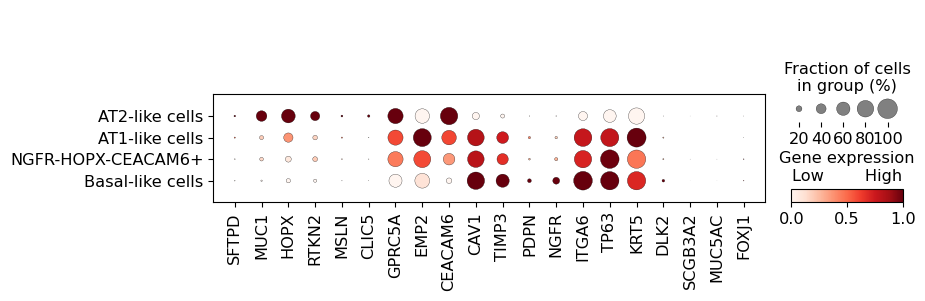

In [6]:
### Figure 4g
### Dotplot showing the expression of examples of cell type markers

from matplotlib import rcParams
rcParams['font.size']=14

genes1 = ['SFTPD', 'MUC1', 
        'HOPX', 'RTKN2', 'MSLN', 'CLIC5', 'GPRC5A', 
        'EMP2', 'CEACAM6', 
        'CAV1', 'TIMP3', 
        'PDPN', 'NGFR', 'ITGA6', 'TP63', 'KRT5',
        'DLK2', 
        'SCGB3A2', 'MUC5AC', 'FOXJ1']
sc.pl.dotplot(filtered, genes1, groupby='cell_type', 
              use_raw=True, standard_scale='var', 
              colorbar_title='Gene expression\nLow        High',
              #save='ct_dotplot.svg'
             )


In [7]:
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high'
pd.crosstab(filtered.obs['bystanders'], filtered.obs.ID).T

bystanders,high,low,zero
ID,,,
24h_infected_DMSO,421,2649,5571
24h_infected_RMC-113,115,1363,6388
24h_uninfected_DMSO,0,0,1369
24h_uninfected_RMC-113,0,0,1833
4h_infected_DMSO,19,43,73
4h_infected_RMC-113,42,107,95
4h_uninfected_DMSO,2,33,218
4h_uninfected_RMC-113,2,40,289


In [9]:
sc.pp.highly_variable_genes(filtered, n_top_genes =2000, batch_key='ID')
sc.pp.pca(filtered, n_comps=50, use_highly_variable=True, svd_solver='arpack')

sc.external.pp.harmony_integrate(filtered, 'ID', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(filtered, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')

sc.tl.umap(filtered)

2024-05-16 15:42:32,561 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-16 15:42:37,030 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-16 15:42:37,082 - harmonypy - INFO - Iteration 1 of 10
2024-05-16 15:42:40,179 - harmonypy - INFO - Iteration 2 of 10
2024-05-16 15:42:42,951 - harmonypy - INFO - Iteration 3 of 10
2024-05-16 15:42:45,827 - harmonypy - INFO - Converged after 3 iterations


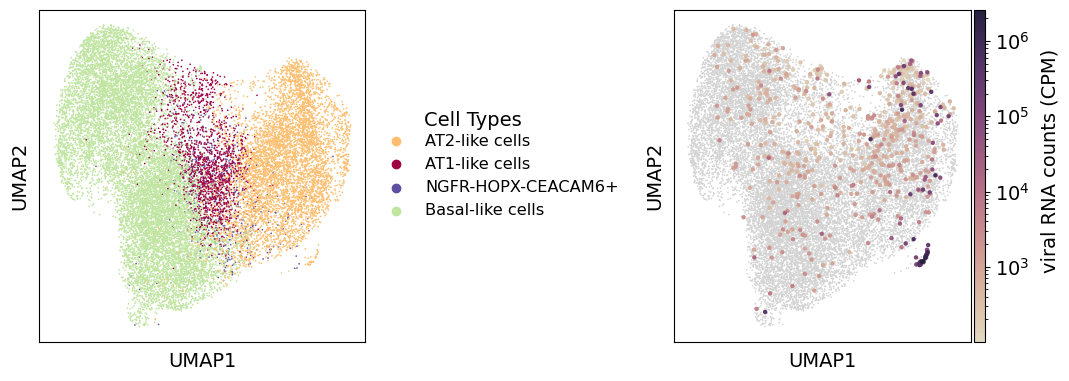

In [11]:
### Figure 4h and Figure 4i
### Umaps showing distinct cell types or SARS-CoV-2 transcripts

filtered.obs['viral_CPM'] = (filtered.obs.viral_counts +1)*1000000 / filtered.obs.total_counts

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[11,4])

filtered.uns['cell_type_colors'] = ['#fdbf6f', '#9e0142', '#5e4fa2', '#bfe5a0', ]
sc.pl.umap(filtered, color=['cell_type',], 
           legend_fontsize='small', show=False, title='', ax=ax1)
ax1.text(1.48, 0.65, 'Cell Types', fontsize='medium',
        rotation='horizontal',
        horizontalalignment='right', transform=ax1.transAxes)


palette = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# Plot all cells as background
sc.pl.umap(filtered, show=False, ax=ax2)
# Plot on top viral_CPM by subsetting data with viral reads >3
sc.pl.umap(filtered[(filtered.obs.viral_counts>3) ],color='viral_CPM', title='', 
            ax=ax2, cmap=palette, show=False, s=40, norm=mpl.colors.LogNorm())
ax2.text(1.3, 0.22, 'viral RNA counts (CPM)', fontsize='medium',
        rotation='vertical',
        horizontalalignment='right', transform=ax2.transAxes)

fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()